# Train linear NCEM

#### Hypothesis: NCEM is reliant on cell-type annotation. We hypothesize that annotation accuracy has a great effect on NCEM output

Aim: Simulate imperfect cell type annotation by shuffling cell types (in different percentages of cells) to investigate NCEM sensibility towards cell-type annotation

Input:
 - Hartmann raw-data in correct file and directory structure as described in `hartmann_data-preparation.ipynb`

Output:
 - 



In [1]:
%load_ext autoreload
%autoreload 2

import ncem
import tensorflow as tf

import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

import helper
import pickle
import random

random.seed(42)
print(random.random()) 

2023-02-20 00:57:15.141801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 00:57:15.314067: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 00:57:15.879785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-20 00:57:15.879834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

sender_receiver_custom module is loaded!
0.6394267984578837


## If errors occur with CUDA

In [2]:
# If `InternalEError: libdevice not found at ./libdevice.10.bc [Op:__inference_one_e_step_2806]`
# --> try including in shell $PATH:
#        `export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda`

# If `"Attempting to perform BLAS operation using StreamExecutor without BLAS support`
# --> try setting a dedicated amount of GPU vram:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)]) # 1500 [MB]
    except RuntimeError as e:
        print('ERROR')

2023-02-20 00:57:17.854507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 00:57:17.876237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 00:57:17.876399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Input

### Which fractions of cells to shuffle in iteration and how many repetitions per fraction

In [3]:
frac_list = [0.001, 0.01, 0.10, 0.50, 1.00]
reps = 15

 ### Paths

In [4]:
data_path_base ="../input-data/raw-data/"
out_path = "../output-data/Hartmann-2021/"
fn_out_cv = out_path + "/results/"

### Dataset specific inputs

In [5]:
data_set = 'hartmann'
data_path = data_path_base + '/Hartmann-2021/'
log_transform = False # Hartmann DS is already arcsinh transformed
use_domain = True
scale_node_size=False
merge_node_types_predefined = True
covar_selection = []
output_layer='linear'


### Manual inputs

In [6]:
model_class = 'interactions'
optimizer = 'adam'
domain_type = 'patient'

learning_rate = 0.05
l1 = 0.
l2 = 0.

batch_size = 58
radius = 35
n_eval_nodes = 10

gs_id = f"tutorial_{model_class}_{radius}_{data_set}_{domain_type}"



### Model and training input

In [7]:
ncv = 3
epochs = 2000 if "tutorial" not in gs_id else 10 
epochs_warmup = 0
max_steps_per_epoch = 20
patience = 100
lr_schedule_min_lr = 1e-10
lr_schedule_factor = 0.5
lr_schedule_patience = 50
val_bs = 16
max_val_steps_per_epoch = 10
shuffle_buffer_size = None

feature_space_id = "standard"
cond_feature_space_id = "type"

use_covar_node_label = False
use_covar_node_position = False
use_covar_graph_covar = False

# Init NCEM stats list

In [8]:
ncem_stats = []

# Iterable NCEM function

In [9]:
def ncem_run(shuffle_frac: float = 0.00, reps: int = 3):

    # Init return dict
    stats = []


    reps_init = reps

    while reps > 0:

        print("\n-------------------------------------------------------------------------------------------------\n")
        print("                                       REP: " + str(abs(reps - reps_init)))
        print("\n-------------------------------------------------------------------------------------------------\n")

        if shuffle_frac != 0.00:

            # Read csv
            new_csv = pd.read_csv("../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv", header=0)

            # Shuffle `Cluster` column
            new_csv['Cluster'] = helper.shuffle(new_csv, 'Cluster', 'Cluster', frac=shuffle_frac)

            # Write new csv file
            new_csv.to_csv("../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv", index=False)


        # Init trainer
        trainer = ncem.train.TrainModelInteractions()
        trainer.init_estim(log_transform=log_transform)

        # Load data
        trainer.estimator.get_data(
            data_origin=data_set,
            data_path=data_path,
            radius=radius,
            graph_covar_selection=covar_selection,
            node_label_space_id=cond_feature_space_id,
            node_feature_space_id=feature_space_id,
            # feature_transformation=transformation_dict[transform_key],
            use_covar_node_position=use_covar_node_position,
            use_covar_node_label=use_covar_node_label,
            use_covar_graph_covar=use_covar_graph_covar,
            # hold_out_covariate=hold_out_covariate,
            domain_type=domain_type,
            # merge_node_types_predefined=merge_node_types_predefined,
        )

        # Define training, validation and testing proportions
        trainer.estimator.split_data_node(
            validation_split=0.1,
            test_split=0.1,
            seed=0
        )

        # Init model
        trainer.estimator.init_model(
            optimizer=optimizer,
            learning_rate=learning_rate,
            n_eval_nodes_per_graph=n_eval_nodes,

            l2_coef=l2,
            l1_coef=l1,
            use_interactions=True,
            use_domain=use_domain,
            scale_node_size=scale_node_size,
            output_layer=output_layer,
        )

        # print("\n-------------------------------- MODEL SUMMARY --------------------------------------------------\n")
        # trainer.estimator.model.training_model.summary()

        # Train
        trainer.estimator.train(
            epochs=epochs,
            epochs_warmup=epochs_warmup,
            batch_size=batch_size,
            max_steps_per_epoch=max_steps_per_epoch,
            validation_batch_size=val_bs,
            max_validation_steps=max_val_steps_per_epoch,
            patience=patience,
            lr_schedule_min_lr=lr_schedule_min_lr,
            lr_schedule_factor=lr_schedule_factor,
            lr_schedule_patience=lr_schedule_patience,
            monitor_partition="val",
            monitor_metric="loss",
            shuffle_buffer_size=shuffle_buffer_size,
            early_stopping=True,
            reduce_lr_plateau=True,
        )

        # Evaluate
        evaluation_test = trainer.estimator.evaluate_any(
            img_keys=trainer.estimator.img_keys_test,
            node_idx=trainer.estimator.nodes_idx_test
        )

        stats.append(evaluation_test)
        stats[-1]['run'] = str(shuffle_frac)

        reps -= 1

    return stats

# Standard NCEM

In [10]:
ncem_stats = ncem_stats + ncem_run(reps=reps)


-------------------------------------------------------------------------------------------------

                                       REP: 0

-------------------------------------------------------------------------------------------------



/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data from raw files
registering celldata


/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.05it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 



2023-02-20 00:57:23.232004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 00:57:23.232765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 00:57:23.232950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 00:57:23.233028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2023-02-20 00:57:25.509039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-20 00:57:25.519151: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5629b7157f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-20 00:57:25.519170: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-02-20 00:57:25.523621: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-20 00:57:25.641296: I tensorflow/compiler/jit/xla_compilation_ca

1/1 - 2s - loss: 38.9475 - custom_mae: 0.4687 - custom_mean_sd: 1.0000 - custom_mse: 0.3259 - custom_mse_scaled: 0.3259 - gaussian_reconstruction_loss: 38.9475 - r_squared: -2.9392e+00 - r_squared_linreg: 0.0034 - val_loss: 34.3375 - val_custom_mae: 0.3056 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1536 - val_custom_mse_scaled: 0.1698 - val_gaussian_reconstruction_loss: 34.3375 - val_r_squared: -9.2695e-01 - val_r_squared_linreg: 0.0422 - lr: 0.0500 - 2s/epoch - 2s/step
Epoch 2/10
1/1 - 0s - loss: 34.4949 - custom_mae: 0.3141 - custom_mean_sd: 0.9512 - custom_mse: 0.1615 - custom_mse_scaled: 0.1785 - gaussian_reconstruction_loss: 34.4949 - r_squared: -9.8802e-01 - r_squared_linreg: 0.0413 - val_loss: 31.3313 - val_custom_mae: 0.2245 - val_custom_mean_sd: 0.9051 - val_custom_mse: 0.0838 - val_custom_mse_scaled: 0.1022 - val_gaussian_reconstruction_loss: 31.3313 - val_r_squared: -6.4906e-02 - val_r_squared_linreg: 0.2068 - lr: 0.0500 - 377ms/epoch - 377ms/step
Epoch 3/10
1/1 - 0s -

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.97it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 37.9111 - custom_mae: 0.4269 - custom_mean_sd: 1.0000 - custom_mse: 0.2683 - custom_mse_scaled: 0.2683 - gaussian_reconstruction_loss: 37.9111 - r_squared: -2.2432e+00 - r_squared_linreg: 0.0078 - val_loss: 33.7061 - val_custom_mae: 0.2761 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1219 - val_custom_mse_scaled: 0.1347 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.54it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.6260 - custom_mae: 0.4533 - custom_mean_sd: 1.0000 - custom_mse: 0.3080 - custom_mse_scaled: 0.3080 - gaussian_reconstruction_loss: 38.6260 - r_squared: -2.7233e+00 - r_squared_linreg: 0.0076 - val_loss: 34.2241 - val_custom_mae: 0.3003 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1479 - val_custom_mse_scaled: 0.1635 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.75it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 37.9591 - custom_mae: 0.4279 - custom_mean_sd: 1.0000 - custom_mse: 0.2710 - custom_mse_scaled: 0.2710 - gaussian_reconstruction_loss: 37.9591 - r_squared: -2.2755e+00 - r_squared_linreg: 0.0032 - val_loss: 33.7829 - val_custom_mae: 0.2774 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1257 - val_custom_mse_scaled: 0.1390 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 55.40it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.3712 - custom_mae: 0.4471 - custom_mean_sd: 1.0000 - custom_mse: 0.2939 - custom_mse_scaled: 0.2939 - gaussian_reconstruction_loss: 38.3712 - r_squared: -2.5522e+00 - r_squared_linreg: 0.0065 - val_loss: 33.9782 - val_custom_mae: 0.2891 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1355 - val_custom_mse_scaled: 0.1498 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.36it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.1910 - custom_mae: 0.4363 - custom_mean_sd: 1.0000 - custom_mse: 0.2838 - custom_mse_scaled: 0.2838 - gaussian_reconstruction_loss: 38.1910 - r_squared: -2.4312e+00 - r_squared_linreg: 0.0018 - val_loss: 34.0055 - val_custom_mae: 0.2885 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1369 - val_custom_mse_scaled: 0.1513 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.85it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.4090 - custom_mae: 0.4498 - custom_mean_sd: 1.0000 - custom_mse: 0.2960 - custom_mse_scaled: 0.2960 - gaussian_reconstruction_loss: 38.4090 - r_squared: -2.5775e+00 - r_squared_linreg: 6.4776e-07 - val_loss: 33.9991 - val_custom_mae: 0.2932 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1366 - val_custom_mse_scaled: 0.1510 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.87it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.6766 - custom_mae: 0.4588 - custom_mean_sd: 1.0000 - custom_mse: 0.3108 - custom_mse_scaled: 0.3108 - gaussian_reconstruction_loss: 38.6766 - r_squared: -2.7573e+00 - r_squared_linreg: 0.0013 - val_loss: 34.1788 - val_custom_mae: 0.3016 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1456 - val_custom_mse_scaled: 0.1609 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.53it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.2549 - custom_mae: 0.4405 - custom_mean_sd: 1.0000 - custom_mse: 0.2874 - custom_mse_scaled: 0.2874 - gaussian_reconstruction_loss: 38.2549 - r_squared: -2.4741e+00 - r_squared_linreg: 1.3095e-05 - val_loss: 33.8969 - val_custom_mae: 0.2850 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1315 - val_custom_mse_scaled: 0.1453 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.62it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.8626 - custom_mae: 0.4656 - custom_mean_sd: 1.0000 - custom_mse: 0.3212 - custom_mse_scaled: 0.3212 - gaussian_reconstruction_loss: 38.8626 - r_squared: -2.8822e+00 - r_squared_linreg: 9.0324e-04 - val_loss: 34.4302 - val_custom_mae: 0.3116 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1583 - val_custom_mse_scaled: 0.1749 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.25it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.7143 - custom_mae: 0.4634 - custom_mean_sd: 1.0000 - custom_mse: 0.3129 - custom_mse_scaled: 0.3129 - gaussian_reconstruction_loss: 38.7143 - r_squared: -2.7826e+00 - r_squared_linreg: 8.1825e-04 - val_loss: 34.1624 - val_custom_mae: 0.3003 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1448 - val_custom_mse_scaled: 0.1600 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.54it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.3602 - custom_mae: 0.4446 - custom_mean_sd: 1.0000 - custom_mse: 0.2932 - custom_mse_scaled: 0.2932 - gaussian_reconstruction_loss: 38.3602 - r_squared: -2.5448e+00 - r_squared_linreg: 4.2168e-05 - val_loss: 34.1208 - val_custom_mae: 0.2981 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1427 - val_custom_mse_scaled: 0.1577 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.27it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.8505 - custom_mae: 0.4638 - custom_mean_sd: 1.0000 - custom_mse: 0.3205 - custom_mse_scaled: 0.3205 - gaussian_reconstruction_loss: 38.8505 - r_squared: -2.8741e+00 - r_squared_linreg: 0.0095 - val_loss: 34.3278 - val_custom_mae: 0.3047 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1531 - val_custom_mse_scaled: 0.1692 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.05it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.2016 - custom_mae: 0.4388 - custom_mean_sd: 1.0000 - custom_mse: 0.2844 - custom_mse_scaled: 0.2844 - gaussian_reconstruction_loss: 38.2016 - r_squared: -2.4383e+00 - r_squared_linreg: 0.0015 - val_loss: 33.9196 - val_custom_mae: 0.2864 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1326 - val_custom_mse_scaled: 0.1465 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.98it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.5240 - custom_mae: 0.4505 - custom_mean_sd: 1.0000 - custom_mse: 0.3023 - custom_mse_scaled: 0.3023 - gaussian_reconstruction_loss: 38.5240 - r_squared: -2.6548e+00 - r_squared_linreg: 3.8968e-04 - val_loss: 34.1572 - val_custom_mae: 0.2977 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1445 - val_custom_mse_scaled: 0.1597 - val_gaussian_reconstruc

# Calculate losses over different shuffled cell-type fractions

### Init file replacement and placeholder

In [11]:
# Make csv placeholder file
os.system("cp ../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv ../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell_BACKUP.csv")

0

### Run NCEM on different cell-type shuffle fractions

In [12]:
for i in frac_list:

    print("\n-------------------------------------------------------------------------------------------------\n")
    print("                                       RUN: " + str(i))
    print("\n-------------------------------------------------------------------------------------------------\n")

    ncem_stats = ncem_stats + ncem_run(shuffle_frac=i, reps=reps)


-------------------------------------------------------------------------------------------------

                                       RUN: 0.001

-------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------

                                       REP: 0

-------------------------------------------------------------------------------------------------

Loading data from raw files
registering celldata


/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.86it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.4668 - custom_mae: 0.4460 - custom_mean_sd: 1.0000 - custom_mse: 0.2992 - custom_mse_scaled: 0.2992 - gaussian_reconstruction_loss: 38.4668 - r_squared: -2.6164e+00 - r_squared_linreg: 6.1454e-07 - val_loss: 34.0630 - val_custom_mae: 0.2921 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1398 - val_custom_mse_scaled: 0.1545 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.52it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.2665 - custom_mae: 0.4382 - custom_mean_sd: 1.0000 - custom_mse: 0.2880 - custom_mse_scaled: 0.2880 - gaussian_reconstruction_loss: 38.2665 - r_squared: -2.4818e+00 - r_squared_linreg: 4.4030e-04 - val_loss: 34.0464 - val_custom_mae: 0.2905 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1390 - val_custom_mse_scaled: 0.1536 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.90it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.4522 - custom_mae: 0.4479 - custom_mean_sd: 1.0000 - custom_mse: 0.2984 - custom_mse_scaled: 0.2984 - gaussian_reconstruction_loss: 38.4522 - r_squared: -2.6066e+00 - r_squared_linreg: 0.0015 - val_loss: 33.9726 - val_custom_mae: 0.2892 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1353 - val_custom_mse_scaled: 0.1495 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.43it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.9672 - custom_mae: 0.4675 - custom_mean_sd: 1.0000 - custom_mse: 0.3270 - custom_mse_scaled: 0.3270 - gaussian_reconstruction_loss: 38.9672 - r_squared: -2.9524e+00 - r_squared_linreg: 0.0025 - val_loss: 34.4771 - val_custom_mae: 0.3142 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1606 - val_custom_mse_scaled: 0.1775 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.97it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 37.9469 - custom_mae: 0.4216 - custom_mean_sd: 1.0000 - custom_mse: 0.2703 - custom_mse_scaled: 0.2703 - gaussian_reconstruction_loss: 37.9469 - r_squared: -2.2673e+00 - r_squared_linreg: 0.0036 - val_loss: 33.7318 - val_custom_mae: 0.2746 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1232 - val_custom_mse_scaled: 0.1361 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.57it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.3116 - custom_mae: 0.4367 - custom_mean_sd: 1.0000 - custom_mse: 0.2905 - custom_mse_scaled: 0.2905 - gaussian_reconstruction_loss: 38.3116 - r_squared: -2.5121e+00 - r_squared_linreg: 7.8373e-06 - val_loss: 34.0730 - val_custom_mae: 0.2891 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1403 - val_custom_mse_scaled: 0.1551 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.26it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.4348 - custom_mae: 0.4477 - custom_mean_sd: 1.0000 - custom_mse: 0.2974 - custom_mse_scaled: 0.2974 - gaussian_reconstruction_loss: 38.4348 - r_squared: -2.5949e+00 - r_squared_linreg: 6.8944e-04 - val_loss: 33.9790 - val_custom_mae: 0.2874 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1356 - val_custom_mse_scaled: 0.1498 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.93it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.4891 - custom_mae: 0.4481 - custom_mean_sd: 1.0000 - custom_mse: 0.3004 - custom_mse_scaled: 0.3004 - gaussian_reconstruction_loss: 38.4891 - r_squared: -2.6314e+00 - r_squared_linreg: 0.0034 - val_loss: 34.1734 - val_custom_mae: 0.3011 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1454 - val_custom_mse_scaled: 0.1606 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.62it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.8337 - custom_mae: 0.4701 - custom_mean_sd: 1.0000 - custom_mse: 0.3195 - custom_mse_scaled: 0.3195 - gaussian_reconstruction_loss: 38.8337 - r_squared: -2.8628e+00 - r_squared_linreg: 6.1274e-04 - val_loss: 34.2287 - val_custom_mae: 0.3036 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1481 - val_custom_mse_scaled: 0.1637 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.75it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5408 - custom_mae: 0.4471 - custom_mean_sd: 1.0000 - custom_mse: 0.3033 - custom_mse_scaled: 0.3033 - gaussian_reconstruction_loss: 38.5408 - r_squared: -2.6661e+00 - r_squared_linreg: 9.7584e-04 - val_loss: 34.1272 - val_custom_mae: 0.2943 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1430 - val_custom_mse_scaled: 0.1581 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.90it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.1445 - custom_mae: 0.4345 - custom_mean_sd: 1.0000 - custom_mse: 0.2813 - custom_mse_scaled: 0.2813 - gaussian_reconstruction_loss: 38.1445 - r_squared: -2.4000e+00 - r_squared_linreg: 1.4354e-04 - val_loss: 33.8751 - val_custom_mae: 0.2836 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1304 - val_custom_mse_scaled: 0.1441 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.69it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 3s - loss: 38.4103 - custom_mae: 0.4448 - custom_mean_sd: 1.0000 - custom_mse: 0.2960 - custom_mse_scaled: 0.2960 - gaussian_reconstruction_loss: 38.4103 - r_squared: -2.5784e+00 - r_squared_linreg: 4.9140e-06 - val_loss: 34.0498 - val_custom_mae: 0.2924 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1391 - val_custom_mse_scaled: 0.1538 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.85it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.6951 - custom_mae: 0.4614 - custom_mean_sd: 1.0000 - custom_mse: 0.3119 - custom_mse_scaled: 0.3119 - gaussian_reconstruction_loss: 38.6951 - r_squared: -2.7697e+00 - r_squared_linreg: 1.0766e-04 - val_loss: 34.1768 - val_custom_mae: 0.3007 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1455 - val_custom_mse_scaled: 0.1608 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.17it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.7847 - custom_mae: 0.4598 - custom_mean_sd: 1.0000 - custom_mse: 0.3168 - custom_mse_scaled: 0.3168 - gaussian_reconstruction_loss: 38.7847 - r_squared: -2.8299e+00 - r_squared_linreg: 0.0035 - val_loss: 34.2562 - val_custom_mae: 0.3006 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1495 - val_custom_mse_scaled: 0.1652 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.31it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.7055 - custom_mae: 0.4611 - custom_mean_sd: 1.0000 - custom_mse: 0.3124 - custom_mse_scaled: 0.3124 - gaussian_reconstruction_loss: 38.7055 - r_squared: -2.7767e+00 - r_squared_linreg: 0.0018 - val_loss: 34.2139 - val_custom_mae: 0.3010 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1474 - val_custom_mse_scaled: 0.1629 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.11it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.3402 - custom_mae: 0.4448 - custom_mean_sd: 1.0000 - custom_mse: 0.2921 - custom_mse_scaled: 0.2921 - gaussian_reconstruction_loss: 38.3402 - r_squared: -2.5314e+00 - r_squared_linreg: 5.0940e-04 - val_loss: 34.0418 - val_custom_mae: 0.2941 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1387 - val_custom_mse_scaled: 0.1533 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.10it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.7204 - custom_mae: 0.4587 - custom_mean_sd: 1.0000 - custom_mse: 0.3133 - custom_mse_scaled: 0.3133 - gaussian_reconstruction_loss: 38.7204 - r_squared: -2.7867e+00 - r_squared_linreg: 0.0015 - val_loss: 34.3463 - val_custom_mae: 0.3087 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1541 - val_custom_mse_scaled: 0.1703 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.69it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 37.9495 - custom_mae: 0.4208 - custom_mean_sd: 1.0000 - custom_mse: 0.2704 - custom_mse_scaled: 0.2704 - gaussian_reconstruction_loss: 37.9495 - r_squared: -2.2690e+00 - r_squared_linreg: 7.6405e-04 - val_loss: 33.7783 - val_custom_mae: 0.2767 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1255 - val_custom_mse_scaled: 0.1387 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.85it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5564 - custom_mae: 0.4543 - custom_mean_sd: 1.0000 - custom_mse: 0.3041 - custom_mse_scaled: 0.3041 - gaussian_reconstruction_loss: 38.5564 - r_squared: -2.6766e+00 - r_squared_linreg: 3.7995e-06 - val_loss: 34.0663 - val_custom_mae: 0.2951 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1400 - val_custom_mse_scaled: 0.1547 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 46.68it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.0098 - custom_mae: 0.4285 - custom_mean_sd: 1.0000 - custom_mse: 0.2738 - custom_mse_scaled: 0.2738 - gaussian_reconstruction_loss: 38.0098 - r_squared: -2.3095e+00 - r_squared_linreg: 0.0012 - val_loss: 33.7820 - val_custom_mae: 0.2770 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1257 - val_custom_mse_scaled: 0.1389 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.51it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.6000 - custom_mae: 0.4524 - custom_mean_sd: 1.0000 - custom_mse: 0.3066 - custom_mse_scaled: 0.3066 - gaussian_reconstruction_loss: 38.6000 - r_squared: -2.7059e+00 - r_squared_linreg: 9.6070e-07 - val_loss: 34.1185 - val_custom_mae: 0.2970 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1426 - val_custom_mse_scaled: 0.1576 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 48.62it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5037 - custom_mae: 0.4478 - custom_mean_sd: 1.0000 - custom_mse: 0.3012 - custom_mse_scaled: 0.3012 - gaussian_reconstruction_loss: 38.5037 - r_squared: -2.6411e+00 - r_squared_linreg: 5.3961e-04 - val_loss: 34.1053 - val_custom_mae: 0.2983 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1419 - val_custom_mse_scaled: 0.1569 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.62it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.6692 - custom_mae: 0.4598 - custom_mean_sd: 1.0000 - custom_mse: 0.3104 - custom_mse_scaled: 0.3104 - gaussian_reconstruction_loss: 38.6692 - r_squared: -2.7523e+00 - r_squared_linreg: 1.4966e-04 - val_loss: 34.0376 - val_custom_mae: 0.2953 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1385 - val_custom_mse_scaled: 0.1531 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.84it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 3s - loss: 38.0188 - custom_mae: 0.4294 - custom_mean_sd: 1.0000 - custom_mse: 0.2743 - custom_mse_scaled: 0.2743 - gaussian_reconstruction_loss: 38.0188 - r_squared: -2.3155e+00 - r_squared_linreg: 0.0042 - val_loss: 33.8070 - val_custom_mae: 0.2813 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1269 - val_custom_mse_scaled: 0.1403 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.26it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.4039 - custom_mae: 0.4481 - custom_mean_sd: 1.0000 - custom_mse: 0.2957 - custom_mse_scaled: 0.2957 - gaussian_reconstruction_loss: 38.4039 - r_squared: -2.5742e+00 - r_squared_linreg: 0.0022 - val_loss: 33.8840 - val_custom_mae: 0.2840 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1308 - val_custom_mse_scaled: 0.1446 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.04it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.2604 - custom_mae: 0.4416 - custom_mean_sd: 1.0000 - custom_mse: 0.2877 - custom_mse_scaled: 0.2877 - gaussian_reconstruction_loss: 38.2604 - r_squared: -2.4778e+00 - r_squared_linreg: 0.0031 - val_loss: 33.9025 - val_custom_mae: 0.2848 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1317 - val_custom_mse_scaled: 0.1456 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.59it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.6027 - custom_mae: 0.4512 - custom_mean_sd: 1.0000 - custom_mse: 0.3067 - custom_mse_scaled: 0.3067 - gaussian_reconstruction_loss: 38.6027 - r_squared: -2.7076e+00 - r_squared_linreg: 9.5962e-04 - val_loss: 34.2068 - val_custom_mae: 0.3025 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1470 - val_custom_mse_scaled: 0.1625 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.02it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5681 - custom_mae: 0.4517 - custom_mean_sd: 1.0000 - custom_mse: 0.3048 - custom_mse_scaled: 0.3048 - gaussian_reconstruction_loss: 38.5681 - r_squared: -2.6844e+00 - r_squared_linreg: 0.0038 - val_loss: 34.0975 - val_custom_mae: 0.2965 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1415 - val_custom_mse_scaled: 0.1564 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 44.26it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.2898 - custom_mae: 0.4435 - custom_mean_sd: 1.0000 - custom_mse: 0.2893 - custom_mse_scaled: 0.2893 - gaussian_reconstruction_loss: 38.2898 - r_squared: -2.4975e+00 - r_squared_linreg: 7.4812e-04 - val_loss: 33.8749 - val_custom_mae: 0.2872 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1304 - val_custom_mse_scaled: 0.1441 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 47.99it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.7463 - custom_mae: 0.4563 - custom_mean_sd: 1.0000 - custom_mse: 0.3147 - custom_mse_scaled: 0.3147 - gaussian_reconstruction_loss: 38.7463 - r_squared: -2.8041e+00 - r_squared_linreg: 0.0124 - val_loss: 34.1314 - val_custom_mae: 0.2959 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1432 - val_custom_mse_scaled: 0.1583 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.16it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.3721 - custom_mae: 0.4452 - custom_mean_sd: 1.0000 - custom_mse: 0.2939 - custom_mse_scaled: 0.2939 - gaussian_reconstruction_loss: 38.3721 - r_squared: -2.5528e+00 - r_squared_linreg: 1.1466e-04 - val_loss: 33.9851 - val_custom_mae: 0.2890 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1359 - val_custom_mse_scaled: 0.1502 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.74it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.2625 - custom_mae: 0.4415 - custom_mean_sd: 1.0000 - custom_mse: 0.2878 - custom_mse_scaled: 0.2878 - gaussian_reconstruction_loss: 38.2625 - r_squared: -2.4792e+00 - r_squared_linreg: 0.0053 - val_loss: 33.8768 - val_custom_mae: 0.2835 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1305 - val_custom_mse_scaled: 0.1442 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.19it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5077 - custom_mae: 0.4528 - custom_mean_sd: 1.0000 - custom_mse: 0.3014 - custom_mse_scaled: 0.3014 - gaussian_reconstruction_loss: 38.5077 - r_squared: -2.6439e+00 - r_squared_linreg: 0.0023 - val_loss: 33.9752 - val_custom_mae: 0.2922 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1354 - val_custom_mse_scaled: 0.1496 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.41it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.9429 - custom_mae: 0.4703 - custom_mean_sd: 1.0000 - custom_mse: 0.3256 - custom_mse_scaled: 0.3256 - gaussian_reconstruction_loss: 38.9429 - r_squared: -2.9361e+00 - r_squared_linreg: 1.2070e-04 - val_loss: 34.1728 - val_custom_mae: 0.3033 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1453 - val_custom_mse_scaled: 0.1606 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.50it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.2970 - custom_mae: 0.4377 - custom_mean_sd: 1.0000 - custom_mse: 0.2897 - custom_mse_scaled: 0.2897 - gaussian_reconstruction_loss: 38.2970 - r_squared: -2.5024e+00 - r_squared_linreg: 5.6254e-04 - val_loss: 33.7916 - val_custom_mae: 0.2806 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1262 - val_custom_mse_scaled: 0.1394 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.31it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.2934 - custom_mae: 0.4383 - custom_mean_sd: 1.0000 - custom_mse: 0.2895 - custom_mse_scaled: 0.2895 - gaussian_reconstruction_loss: 38.2934 - r_squared: -2.4999e+00 - r_squared_linreg: 0.0061 - val_loss: 33.7877 - val_custom_mae: 0.2777 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1260 - val_custom_mse_scaled: 0.1392 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.59it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.9541 - custom_mae: 0.4684 - custom_mean_sd: 1.0000 - custom_mse: 0.3262 - custom_mse_scaled: 0.3262 - gaussian_reconstruction_loss: 38.9541 - r_squared: -2.9436e+00 - r_squared_linreg: 6.9774e-04 - val_loss: 34.1727 - val_custom_mae: 0.3001 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1453 - val_custom_mse_scaled: 0.1606 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.14it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 39.0470 - custom_mae: 0.4671 - custom_mean_sd: 1.0000 - custom_mse: 0.3314 - custom_mse_scaled: 0.3314 - gaussian_reconstruction_loss: 39.0470 - r_squared: -3.0060e+00 - r_squared_linreg: 7.9191e-04 - val_loss: 34.2743 - val_custom_mae: 0.3061 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1504 - val_custom_mse_scaled: 0.1663 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 55.11it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5388 - custom_mae: 0.4493 - custom_mean_sd: 1.0000 - custom_mse: 0.3032 - custom_mse_scaled: 0.3032 - gaussian_reconstruction_loss: 38.5388 - r_squared: -2.6648e+00 - r_squared_linreg: 9.6379e-04 - val_loss: 33.8686 - val_custom_mae: 0.2844 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1300 - val_custom_mse_scaled: 0.1437 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:02<00:00, 23.91it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 39.2043 - custom_mae: 0.4773 - custom_mean_sd: 1.0000 - custom_mse: 0.3401 - custom_mse_scaled: 0.3401 - gaussian_reconstruction_loss: 39.2043 - r_squared: -3.1117e+00 - r_squared_linreg: 0.0016 - val_loss: 34.3316 - val_custom_mae: 0.3099 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1533 - val_custom_mse_scaled: 0.1694 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.29it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 39.0248 - custom_mae: 0.4704 - custom_mean_sd: 1.0000 - custom_mse: 0.3302 - custom_mse_scaled: 0.3302 - gaussian_reconstruction_loss: 39.0248 - r_squared: -2.9911e+00 - r_squared_linreg: 1.7460e-04 - val_loss: 34.0916 - val_custom_mae: 0.2996 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1412 - val_custom_mse_scaled: 0.1561 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.56it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.4840 - custom_mae: 0.4460 - custom_mean_sd: 1.0000 - custom_mse: 0.3001 - custom_mse_scaled: 0.3001 - gaussian_reconstruction_loss: 38.4840 - r_squared: -2.6279e+00 - r_squared_linreg: 2.5460e-04 - val_loss: 33.8765 - val_custom_mae: 0.2855 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1304 - val_custom_mse_scaled: 0.1442 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.56it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.8576 - custom_mae: 0.4641 - custom_mean_sd: 1.0000 - custom_mse: 0.3209 - custom_mse_scaled: 0.3209 - gaussian_reconstruction_loss: 38.8576 - r_squared: -2.8788e+00 - r_squared_linreg: 0.0046 - val_loss: 34.0576 - val_custom_mae: 0.2975 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1395 - val_custom_mse_scaled: 0.1542 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.59it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.6509 - custom_mae: 0.4480 - custom_mean_sd: 1.0000 - custom_mse: 0.3094 - custom_mse_scaled: 0.3094 - gaussian_reconstruction_loss: 38.6509 - r_squared: -2.7401e+00 - r_squared_linreg: 1.6469e-06 - val_loss: 34.1288 - val_custom_mae: 0.2969 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1431 - val_custom_mse_scaled: 0.1582 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.14it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.7877 - custom_mae: 0.4623 - custom_mean_sd: 1.0000 - custom_mse: 0.3170 - custom_mse_scaled: 0.3170 - gaussian_reconstruction_loss: 38.7877 - r_squared: -2.8319e+00 - r_squared_linreg: 3.8430e-04 - val_loss: 34.0857 - val_custom_mae: 0.2996 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1410 - val_custom_mse_scaled: 0.1558 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 44.60it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 39.1364 - custom_mae: 0.4749 - custom_mean_sd: 1.0000 - custom_mse: 0.3364 - custom_mse_scaled: 0.3364 - gaussian_reconstruction_loss: 39.1364 - r_squared: -3.0661e+00 - r_squared_linreg: 0.0011 - val_loss: 34.2444 - val_custom_mae: 0.3067 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1489 - val_custom_mse_scaled: 0.1646 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.69it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.9763 - custom_mae: 0.4705 - custom_mean_sd: 1.0000 - custom_mse: 0.3275 - custom_mse_scaled: 0.3275 - gaussian_reconstruction_loss: 38.9763 - r_squared: -2.9586e+00 - r_squared_linreg: 6.5215e-05 - val_loss: 34.1928 - val_custom_mae: 0.3042 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1463 - val_custom_mse_scaled: 0.1617 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.33it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5064 - custom_mae: 0.4436 - custom_mean_sd: 1.0000 - custom_mse: 0.3014 - custom_mse_scaled: 0.3014 - gaussian_reconstruction_loss: 38.5064 - r_squared: -2.6430e+00 - r_squared_linreg: 5.0973e-05 - val_loss: 33.9889 - val_custom_mae: 0.2919 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1361 - val_custom_mse_scaled: 0.1504 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.42it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 39.1541 - custom_mae: 0.4772 - custom_mean_sd: 1.0000 - custom_mse: 0.3374 - custom_mse_scaled: 0.3374 - gaussian_reconstruction_loss: 39.1541 - r_squared: -3.0780e+00 - r_squared_linreg: 3.3790e-05 - val_loss: 34.2578 - val_custom_mae: 0.3071 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1496 - val_custom_mse_scaled: 0.1653 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.10it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.7447 - custom_mae: 0.4561 - custom_mean_sd: 1.0000 - custom_mse: 0.3146 - custom_mse_scaled: 0.3146 - gaussian_reconstruction_loss: 38.7447 - r_squared: -2.8030e+00 - r_squared_linreg: 2.1215e-04 - val_loss: 34.1032 - val_custom_mae: 0.2968 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1418 - val_custom_mse_scaled: 0.1567 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 48.49it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.9157 - custom_mae: 0.4646 - custom_mean_sd: 1.0000 - custom_mse: 0.3241 - custom_mse_scaled: 0.3241 - gaussian_reconstruction_loss: 38.9157 - r_squared: -2.9179e+00 - r_squared_linreg: 6.3798e-04 - val_loss: 34.0420 - val_custom_mae: 0.2950 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1388 - val_custom_mse_scaled: 0.1533 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.21it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.8594 - custom_mae: 0.4651 - custom_mean_sd: 1.0000 - custom_mse: 0.3210 - custom_mse_scaled: 0.3210 - gaussian_reconstruction_loss: 38.8594 - r_squared: -2.8801e+00 - r_squared_linreg: 8.8297e-06 - val_loss: 34.0466 - val_custom_mae: 0.2932 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1390 - val_custom_mse_scaled: 0.1536 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.46it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.8029 - custom_mae: 0.4584 - custom_mean_sd: 1.0000 - custom_mse: 0.3178 - custom_mse_scaled: 0.3178 - gaussian_reconstruction_loss: 38.8029 - r_squared: -2.8421e+00 - r_squared_linreg: 0.0053 - val_loss: 34.1266 - val_custom_mae: 0.2992 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1430 - val_custom_mse_scaled: 0.1580 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 48.58it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.7739 - custom_mae: 0.4573 - custom_mean_sd: 1.0000 - custom_mse: 0.3162 - custom_mse_scaled: 0.3162 - gaussian_reconstruction_loss: 38.7739 - r_squared: -2.8227e+00 - r_squared_linreg: 0.0025 - val_loss: 34.1116 - val_custom_mae: 0.2993 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1423 - val_custom_mse_scaled: 0.1572 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.32it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.8410 - custom_mae: 0.4664 - custom_mean_sd: 1.0000 - custom_mse: 0.3200 - custom_mse_scaled: 0.3200 - gaussian_reconstruction_loss: 38.8410 - r_squared: -2.8677e+00 - r_squared_linreg: 0.0053 - val_loss: 34.1314 - val_custom_mae: 0.3010 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1432 - val_custom_mse_scaled: 0.1583 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.97it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.8503 - custom_mae: 0.4625 - custom_mean_sd: 1.0000 - custom_mse: 0.3205 - custom_mse_scaled: 0.3205 - gaussian_reconstruction_loss: 38.8503 - r_squared: -2.8739e+00 - r_squared_linreg: 0.0021 - val_loss: 34.1298 - val_custom_mae: 0.3005 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1432 - val_custom_mse_scaled: 0.1582 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 49.17it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.4403 - custom_mae: 0.4428 - custom_mean_sd: 1.0000 - custom_mse: 0.2977 - custom_mse_scaled: 0.2977 - gaussian_reconstruction_loss: 38.4403 - r_squared: -2.5986e+00 - r_squared_linreg: 0.0010 - val_loss: 33.9368 - val_custom_mae: 0.2906 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1335 - val_custom_mse_scaled: 0.1475 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.76it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 39.0207 - custom_mae: 0.4687 - custom_mean_sd: 1.0000 - custom_mse: 0.3299 - custom_mse_scaled: 0.3299 - gaussian_reconstruction_loss: 39.0207 - r_squared: -2.9884e+00 - r_squared_linreg: 2.3043e-04 - val_loss: 34.1999 - val_custom_mae: 0.3022 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1467 - val_custom_mse_scaled: 0.1621 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 43.63it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 39.2026 - custom_mae: 0.4711 - custom_mean_sd: 1.0000 - custom_mse: 0.3400 - custom_mse_scaled: 0.3400 - gaussian_reconstruction_loss: 39.2026 - r_squared: -3.1105e+00 - r_squared_linreg: 4.4930e-04 - val_loss: 34.3638 - val_custom_mae: 0.3078 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1549 - val_custom_mse_scaled: 0.1712 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 48.44it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 39.3395 - custom_mae: 0.4858 - custom_mean_sd: 1.0000 - custom_mse: 0.3476 - custom_mse_scaled: 0.3476 - gaussian_reconstruction_loss: 39.3395 - r_squared: -3.2024e+00 - r_squared_linreg: 0.0035 - val_loss: 34.3268 - val_custom_mae: 0.3103 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1531 - val_custom_mse_scaled: 0.1692 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 42.61it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.9075 - custom_mae: 0.4608 - custom_mean_sd: 1.0000 - custom_mse: 0.3237 - custom_mse_scaled: 0.3237 - gaussian_reconstruction_loss: 38.9075 - r_squared: -2.9123e+00 - r_squared_linreg: 0.0027 - val_loss: 34.1362 - val_custom_mae: 0.3012 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1435 - val_custom_mse_scaled: 0.1586 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 43.36it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 39.3656 - custom_mae: 0.4848 - custom_mean_sd: 1.0000 - custom_mse: 0.3491 - custom_mse_scaled: 0.3491 - gaussian_reconstruction_loss: 39.3656 - r_squared: -3.2200e+00 - r_squared_linreg: 2.2539e-04 - val_loss: 34.2252 - val_custom_mae: 0.3043 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1480 - val_custom_mse_scaled: 0.1635 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 43.46it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.6686 - custom_mae: 0.4524 - custom_mean_sd: 1.0000 - custom_mse: 0.3104 - custom_mse_scaled: 0.3104 - gaussian_reconstruction_loss: 38.6686 - r_squared: -2.7519e+00 - r_squared_linreg: 6.7393e-05 - val_loss: 34.0834 - val_custom_mae: 0.2961 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1408 - val_custom_mse_scaled: 0.1556 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 55.71it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.9829 - custom_mae: 0.4707 - custom_mean_sd: 1.0000 - custom_mse: 0.3278 - custom_mse_scaled: 0.3278 - gaussian_reconstruction_loss: 38.9829 - r_squared: -2.9630e+00 - r_squared_linreg: 0.0019 - val_loss: 34.2166 - val_custom_mae: 0.3058 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1475 - val_custom_mse_scaled: 0.1630 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 55.31it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 39.1803 - custom_mae: 0.4740 - custom_mean_sd: 1.0000 - custom_mse: 0.3388 - custom_mse_scaled: 0.3388 - gaussian_reconstruction_loss: 39.1803 - r_squared: -3.0956e+00 - r_squared_linreg: 4.9577e-04 - val_loss: 34.3098 - val_custom_mae: 0.3066 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1522 - val_custom_mse_scaled: 0.1682 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 55.21it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 39.0326 - custom_mae: 0.4692 - custom_mean_sd: 1.0000 - custom_mse: 0.3306 - custom_mse_scaled: 0.3306 - gaussian_reconstruction_loss: 39.0326 - r_squared: -2.9963e+00 - r_squared_linreg: 0.0017 - val_loss: 34.1587 - val_custom_mae: 0.3023 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1446 - val_custom_mse_scaled: 0.1598 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.76it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.7895 - custom_mae: 0.4588 - custom_mean_sd: 1.0000 - custom_mse: 0.3171 - custom_mse_scaled: 0.3171 - gaussian_reconstruction_loss: 38.7895 - r_squared: -2.8331e+00 - r_squared_linreg: 0.0011 - val_loss: 34.0502 - val_custom_mae: 0.2949 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1392 - val_custom_mse_scaled: 0.1538 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 53.57it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 39.0438 - custom_mae: 0.4709 - custom_mean_sd: 1.0000 - custom_mse: 0.3312 - custom_mse_scaled: 0.3312 - gaussian_reconstruction_loss: 39.0438 - r_squared: -3.0039e+00 - r_squared_linreg: 4.6956e-04 - val_loss: 34.0469 - val_custom_mae: 0.2948 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1390 - val_custom_mse_scaled: 0.1536 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 50.87it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.6552 - custom_mae: 0.4543 - custom_mean_sd: 1.0000 - custom_mse: 0.3096 - custom_mse_scaled: 0.3096 - gaussian_reconstruction_loss: 38.6552 - r_squared: -2.7429e+00 - r_squared_linreg: 0.0045 - val_loss: 34.0789 - val_custom_mae: 0.2978 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1406 - val_custom_mse_scaled: 0.1554 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.08it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.8298 - custom_mae: 0.4635 - custom_mean_sd: 1.0000 - custom_mse: 0.3193 - custom_mse_scaled: 0.3193 - gaussian_reconstruction_loss: 38.8298 - r_squared: -2.8602e+00 - r_squared_linreg: 0.0041 - val_loss: 34.0621 - val_custom_mae: 0.2963 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1398 - val_custom_mse_scaled: 0.1545 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.41it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.7322 - custom_mae: 0.4522 - custom_mean_sd: 1.0000 - custom_mse: 0.3139 - custom_mse_scaled: 0.3139 - gaussian_reconstruction_loss: 38.7322 - r_squared: -2.7946e+00 - r_squared_linreg: 0.0019 - val_loss: 34.1065 - val_custom_mae: 0.2947 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1420 - val_custom_mse_scaled: 0.1569 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 51.91it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 38.5365 - custom_mae: 0.4459 - custom_mean_sd: 1.0000 - custom_mse: 0.3030 - custom_mse_scaled: 0.3030 - gaussian_reconstruction_loss: 38.5365 - r_squared: -2.6632e+00 - r_squared_linreg: 1.3574e-04 - val_loss: 33.9767 - val_custom_mae: 0.2884 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1355 - val_custom_mse_scaled: 0.1497 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.07it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 2s - loss: 39.1526 - custom_mae: 0.4770 - custom_mean_sd: 1.0000 - custom_mse: 0.3373 - custom_mse_scaled: 0.3373 - gaussian_reconstruction_loss: 39.1526 - r_squared: -3.0770e+00 - r_squared_linreg: 4.8462e-05 - val_loss: 34.2602 - val_custom_mae: 0.3058 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1497 - val_custom_mse_scaled: 0.1655 - val_gaussian_reconstruc

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 52.39it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.4899 - custom_mae: 0.4472 - custom_mean_sd: 1.0000 - custom_mse: 0.3005 - custom_mse_scaled: 0.3005 - gaussian_reconstruction_loss: 38.4899 - r_squared: -2.6319e+00 - r_squared_linreg: 0.0028 - val_loss: 33.9382 - val_custom_mae: 0.2901 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1335 - val_custom_mse_scaled: 0.1476 - val_gaussian_reconstruction

/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/ncem/data.py:2389: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  celldata = AnnData(
/home/ifichtner/mambaforge/envs/squidpyTF/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:01<00:00, 54.69it/s]


Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51930 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 

Epoch 1/10
1/1 - 1s - loss: 38.6278 - custom_mae: 0.4506 - custom_mean_sd: 1.0000 - custom_mse: 0.3081 - custom_mse_scaled: 0.3081 - gaussian_reconstruction_loss: 38.6278 - r_squared: -2.7245e+00 - r_squared_linreg: 0.0035 - val_loss: 34.0016 - val_custom_mae: 0.2915 - val_custom_mean_sd: 0.9512 - val_custom_mse: 0.1367 - val_custom_mse_scaled: 0.1511 - val_gaussian_reconstruction

In [13]:
ncem_stats_df = pd.DataFrame(ncem_stats, dtype='float64')
ncem_stats_df['run'] = pd.Categorical(ncem_stats_df['run'])
ncem_stats_df

,loss,custom_mae,custom_mean_sd,custom_mse,custom_mse_scaled,gaussian_reconstruction_loss,r_squared,r_squared_linreg,run
0,16.993790,0.152366,0.605925,0.039729,0.108233,16.993792,0.490276,0.592929,0.0
1,16.902565,0.151126,0.605529,0.038299,0.104470,16.902567,0.509631,0.588677,0.0
2,16.989515,0.152790,0.606211,0.039370,0.107052,16.989508,0.495382,0.593995,0.0
3,16.909864,0.150554,0.605751,0.038201,0.104133,16.909857,0.511372,0.589544,0.0
4,16.975536,0.153765,0.605843,0.039442,0.107477,16.975546,0.493151,0.589809,0.0
...,...,...,...,...,...,...,...,...,...
85,17.700157,0.181544,0.606343,0.053752,0.146102,17.700148,0.308911,0.425215,1.0
86,17.497068,0.172681,0.606443,0.049509,0.134516,17.497063,0.360257,0.460668,1.0
87,17.690031,0.181532,0.606242,0.053628,0.145850,17.690039,0.311145,0.426858,1.0
88,17.460945,0.172785,0.606069,0.049140,0.133711,17.460934,0.369192,0.464950,1.0


### Recover original csv

In [14]:
os.remove("../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv")

os.rename(
    "../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell_BACKUP.csv",
    "../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv",
)

# Plot

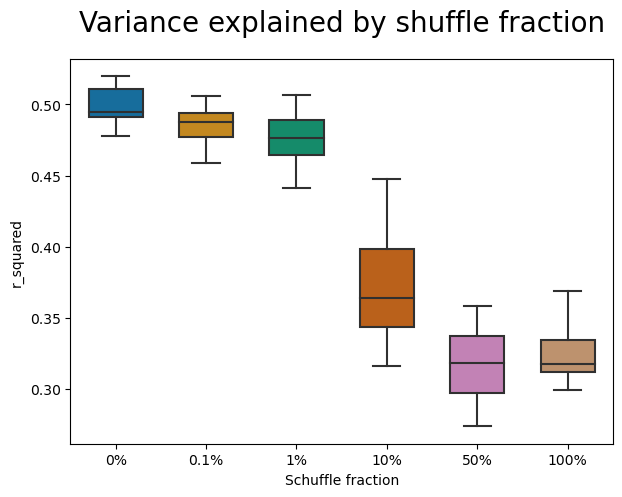

In [15]:
fig, ax = plt.subplots(figsize=(7,5))

sns.boxplot(

    data=ncem_stats_df, 
    x='run', 
    y='r_squared', 
    flierprops={"marker": "o"},

    width=0.6,

    ax=ax

)

ax.set_title("Variance explained by shuffle fraction", fontsize=20, y=1.05)
ax.set_xticklabels(["0%", "0.1%", "1%", "10%", "50%", "100%"])
ax.set_xlabel("Schuffle fraction")

plt.savefig("../figures/hartmann/ncem_interactions_cell-type_shuffling.png")
plt.show()

# Save the dataframe

In [16]:
ncem_stats_df.to_csv("../output-data/hartmann/hartmann_ncem_cell-type-shuffling.csv")